In [1]:
import os
import sys
from pathlib import Path

# Ensure project root is on sys.path so 'backtester' imports work
cwd = Path(os.getcwd())
candidates = [cwd, cwd.parent, Path("..").resolve()]
for p in candidates:
    if (p / "backtester").exists() and str(p) not in sys.path:
        sys.path.insert(0, str(p))
        break

print("PYTHONPATH set. Using root:", sys.path[0])

PYTHONPATH set. Using root: c:\Users\User\Desktop\Crypto strategy backtest


## Load Data

In [2]:
import pandas as pd

def load_crypto_parquet_data(coin_name: str, timeframe: str = "5m", nM: int = 54, section: str = "UTC") -> pd.DataFrame:
    df = pd.read_parquet(fr'C:\Users\User\Desktop\Crypto\{coin_name}_{timeframe}_{nM}M_{section}.parquet')
    return df
def generate_us_session_bars_info(df, include_holidays: bool = False):
    # 確保時間有時區資訊
    df['dt_ny'] = pd.to_datetime(df['dt_utc'], utc=True).dt.tz_convert('America/New_York')

    # 取日期（當地日曆）
    df['date'] = df['dt_ny'].dt.date
    df['weekday'] = df['dt_ny'].dt.day_name() 
    # 對每天依時間排序並編號
    df = df.sort_values(['date', 'dt_ny']).reset_index(drop=True)
    df['bar_index'] = df.groupby('date').cumcount() + 1  # 第幾根K線，從1開始
    if not include_holidays:
        weekday = ['Monday','Tuesday','Wednesday','Thursday','Friday']
    else:
        weekday = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    df = df.loc[df['weekday'].isin(weekday)]
    # 查看結果
    df.set_index('dt_utc', inplace=True)
    # print(df[['dt_ny', 'date', 'weekday', 'bar_index']].head(5))

    return df
def generate_allday_bars_info(df, include_holidays: bool = True):
# 確保時間有時區資訊
    df['dt_ny'] = pd.to_datetime(df['dt_utc'], utc=True).dt.tz_convert('America/New_York')

    # 取日期（當地日曆）
    df['date'] = df['dt_ny'].dt.date
    df['time'] = df['dt_ny'].dt.time
    df['weekday'] = df['dt_ny'].dt.day_name() 
    # 對每天依時間排序並編號
    df = df.sort_values(['date', 'dt_ny']).reset_index(drop=True)
    df['bar_index'] = df.groupby('date').cumcount() + 1  # 第幾根K線，從1開始
    if not include_holidays:
        weekday = ['Monday','Tuesday','Wednesday','Thursday','Friday']
    else:
        weekday = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    df = df.loc[df['weekday'].isin(weekday)]
    # 查看結果
    df.set_index('dt_utc', inplace=True)
    # print(df[['dt_ny', 'date', 'weekday', 'bar_index']].head(5))

    return df

In [ ]:
coin_name = 'ETH'  # 可更改為 'ETH', 'SOL', 'BTC', 'ADA', 'PAXG' 等等
nM = 48
timeframe = "5m"
section = "UTC"

df = load_crypto_parquet_data(coin_name=coin_name, timeframe=timeframe, nM=nM, section=section)
df = generate_allday_bars_info(df, include_holidays=False)


## Split Data

In [14]:
# 分成n等分windows
def split_into_windows(df: pd.DataFrame, n_windows: int, overlap_ratio: float = 0.0) -> list[pd.DataFrame]:
    unique_dates = df.index.unique()
    n_dates = len(unique_dates)
    window_size = n_dates // n_windows
    windows = []
    end_idx = 0
    total_windows = (n_dates - window_size)//(int(window_size * (1 - overlap_ratio))) + 1 if overlap_ratio > 0 else n_windows
    for i in range(total_windows):
        start_idx = end_idx
        if i == total_windows - 1:  # 最後一個視窗包含剩餘的日期
            end_idx = n_dates
        if overlap_ratio > 0 and i > 0:
            overlap_size = int(window_size * overlap_ratio)
            start_idx -= overlap_size
        end_idx = start_idx + window_size
        window_dates = unique_dates[start_idx:end_idx]
        window_df = df[df.index.isin(window_dates)].copy()
        windows.append(window_df)
    return windows
def split_into_train_test(df: pd.DataFrame, train_pct: float = 0.7) -> tuple[pd.DataFrame, pd.DataFrame]:
    unique_dates = df.index.unique()
    n_dates = len(unique_dates)
    train_size = int(n_dates * train_pct)
    train_dates = unique_dates[:train_size]
    test_dates = unique_dates[train_size:]
    train_df = df[df.index.isin(train_dates)].copy()
    test_df = df[df.index.isin(test_dates)].copy()
    return train_df, test_df

In [15]:
splited_dfs = split_into_windows(df, n_windows=5, overlap_ratio=0)
splited_train_test_dfs = [split_into_train_test(window_df, train_pct=0.7) for window_df in splited_dfs]

## Build Strategy

In [16]:
from backtester.models import Position, Side, ActionType, BacktestConfig
from backtester.engine import BacktestEngine
from backtester.strategy_base import StrategyContext
from backtester.strategies.ALBO_strategy import ALBOStrategy, ALBOParams
from typing import Any, Dict, List
from itertools import product
def build_param_combinations(grid: Dict[str, List[Any]]) -> List[Dict[str, Any]]:
    """
    將 param_grid 展開成所有組合，每個組合是一個 dict。
    grid 的值必須是 list/tuple 等 iterable。
    """
    keys = list(grid.keys())
    values_lists = [grid[k] for k in keys]
    combos = [dict(zip(keys, vals)) for vals in product(*values_lists)]
    return combos
def tune_strategy_params(train_df: pd.DataFrame, test_df: pd.DataFrame, param_grid: dict, best_n_params: int, engine) -> dict:
    best_params = None
    best_performance = -float('inf')
    params_combinations = build_param_combinations(param_grid)
        
    performance_list = []

    for params in params_combinations:
        strat_params = ALBOParams(**params)
        strat = ALBOStrategy(strat_params)
        train_result = engine.run(train_df, strat)
        performance = train_result.equity_curve.values[-1] - train_result.equity_curve.values[0]  # 總收益作為績效指標
        unique_days = train_df.index.normalize().unique()
        performance_per_day = performance / (len(unique_days))

        if performance_per_day > best_performance:
            best_performance = performance_per_day
        performance_list.append((params, performance_per_day, len(train_result.trades)))
    performance_list.sort(key=lambda x: x[1], reverse=True)
    best_params_list = performance_list[:best_n_params]

    train_vs_test_results = []
    for params, perf, n_trades in best_params_list:
        strat_params = ALBOParams(**params)
        strat = ALBOStrategy(strat_params)
        test_result = engine.run(test_df, strat)
        test_performance = test_result.equity_curve.values[-1] - test_result.equity_curve.values[0]
        unique_days = test_df.index.normalize().unique()
        test_performance_per_day = test_performance / (len(unique_days))
        perf_diff = test_performance_per_day - perf
        print(f"Params: {params}, Train Perf/Day: {perf}, Test Perf/Day: {test_performance_per_day}, Trades: {len(test_result.trades)}, Perf Diff: {perf_diff}")
        train_vs_test_results.append((params, perf, test_performance_per_day, perf_diff))

    return train_vs_test_results
def test_strategy_with_params(test_df: pd.DataFrame, params: dict, engine) -> Any:
    strat_params = ALBOParams(**params)
    strat = ALBOStrategy(strat_params)
    test_result = engine.run(test_df, strat)
    performance = test_result.equity_curve.values[-1] - test_result.equity_curve.values[0]
    unique_days = test_df.index.normalize().unique()
    performance_per_day = performance / (len(unique_days))
    return performance_per_day, test_result


In [17]:
cfg = BacktestConfig(initial_cash=10000, fee_rate=0.0004, slippage_bps=0.0, conservative_intrabar=True)
engine = BacktestEngine(cfg)

In [18]:
for param, values in ALBOParams.__annotations__.items():
      print(f"Parameter: {param} | Type: {values}")  # 查看可調參數

Parameter: break_out_series_n | Type: int
Parameter: break_out_n_bars | Type: int
Parameter: BO_n_times_atr | Type: float
Parameter: max_notional_pct | Type: float
Parameter: min_qty | Type: float
Parameter: sl_atr_like | Type: float
Parameter: fixed_sl_pct | Type: float
Parameter: rr | Type: float
Parameter: time_exit_bars | Type: int
Parameter: allow_side | Type: Optional[Side]


In [19]:

param_grid = {
    'rr': [1.5, 3],
    'break_out_n_bars': [10, 20, 30],
    'break_out_series_n': [2, 3, 4, 5],
    'BO_n_times_atr': [0.5, 1.0, 1.5, 2],
}
param_grid = {
    'rr': [1.5],
    'break_out_n_bars': [10],
    'break_out_series_n': [2],
    'BO_n_times_atr': [0.5],
}
best_n_params = 2
best_params_list = []
start_window = 0
for i in range(start_window, len(splited_train_test_dfs)):
    print(f"=== Window {i+1} ===")
    best_params =  tune_strategy_params(
        train_df=splited_train_test_dfs[i][0],
        test_df=splited_train_test_dfs[i][1],
        param_grid=param_grid,
        best_n_params=best_n_params,
        engine=engine
    )
    # print("Best Params:")
    for params, perf, test_perf, perf_diff in best_params:
        pass
        # print(f"Params: {params}, Performance per day: {perf}, Test Performance per day: {test_perf}, Performance Difference: {perf_diff}")
    best_params_list.append(best_params)



=== Window 1 ===
Params: {'rr': 1.5, 'break_out_n_bars': 10, 'break_out_series_n': 2, 'BO_n_times_atr': 0.5}, Train Perf/Day: -259.3476048711966, Test Perf/Day: -271.3286656268608, Trades: 795, Perf Diff: -11.981060755664203
=== Window 2 ===
Params: {'rr': 1.5, 'break_out_n_bars': 10, 'break_out_series_n': 2, 'BO_n_times_atr': 0.5}, Train Perf/Day: -429.2525974614695, Test Perf/Day: -576.1075763390178, Trades: 794, Perf Diff: -146.85497887754826
=== Window 3 ===
Params: {'rr': 1.5, 'break_out_n_bars': 10, 'break_out_series_n': 2, 'BO_n_times_atr': 0.5}, Train Perf/Day: -387.3734128954931, Test Perf/Day: -259.1968316728037, Trades: 809, Perf Diff: 128.17658122268944
=== Window 4 ===
Params: {'rr': 1.5, 'break_out_n_bars': 10, 'break_out_series_n': 2, 'BO_n_times_atr': 0.5}, Train Perf/Day: -387.4400546397198, Test Perf/Day: -435.6203449617207, Trades: 878, Perf Diff: -48.18029032200093
=== Window 5 ===
Params: {'rr': 1.5, 'break_out_n_bars': 10, 'break_out_series_n': 2, 'BO_n_times_atr'

In [20]:
for i in range(start_window, len(splited_train_test_dfs)):
    print(f"=== Window {i+1} Test Results ===")
    for params, train_perf, _ in best_params_list[i-start_window]:
        test_perf, test_result = test_strategy_with_params(
            test_df=splited_train_test_dfs[i][1],
            params=params,
            engine=engine
        ) 
        print(f"Test Result with Params: {params}, performance per day: {test_perf}, Trades: {len(test_result.trades)} , performance diff: {test_perf - train_perf}")

=== Window 1 Test Results ===


ValueError: too many values to unpack (expected 3)

## analytics

In [21]:
cfg = BacktestConfig(initial_cash=10000, fee_rate=0.0, slippage_bps=0.0, conservative_intrabar=True)
engine = BacktestEngine(cfg)

In [ ]:
from backtester.analytics import basic_metrics
from dataclasses import replace
params = ALBOParams(
    break_out_series_n = 3, # BO定義:連續突破K線數
    break_out_n_bars = 20, # 突破區間長度（K線數）
    BO_n_times_atr= 2,
    max_notional_pct = 2, # 最大虧損佔資金比例%
    min_qty = 0.0001, # 最小BTC下單量
    sl_atr_like = 0.0,  # MVP不做ATR，示範保留欄位
    rr = 1.5,           # TP = SL距離 * rr
    time_exit_bars = 50,
    allow_side=Side.LONG,
)
for fee_rate in [0.00025]:
    strategy = ALBOStrategy(params)
    cfg2 = replace(cfg, fee_rate=fee_rate)
    engine = BacktestEngine(cfg2)
    print(engine.config.fee_rate)
    result = engine.run(df, strategy)
    metrics = basic_metrics(result)
    print(f"=== Fee Rate: {fee_rate} ===")
    for k, v in metrics.items():
        print(f"{k}: {v}")

0.00025
=== Fee Rate: 0.00025 ===
trades: 582.0
win_rate: 0.44329896907216493
avg_pnl: 3.4102931443504674
profit_factor: 1.0364230492055377
max_drawdown: -0.4927696129159709
sharpe_ratio: 0.2568940393487337
avg_win_held_bars: 27.95736434108527
avg_loss_held_bars: 29.191358024691358


In [23]:
trades = pd.DataFrame([t.__dict__ for t in result.trades])
trade_grouped = trades.groupby('exit_type').agg({'pnl': ['mean', 'sum']}).reset_index()
print(trade_grouped)
# plt.hist(sort_pnls, bins=100)
# plt.show()

       exit_type         pnl              
                        mean           sum
0    ExitType.SL -207.321022 -21354.065255
1  ExitType.TIME  -12.059127  -1109.439710
2    ExitType.TP  292.484856  19596.485369


### Strategy Performance vs Product price

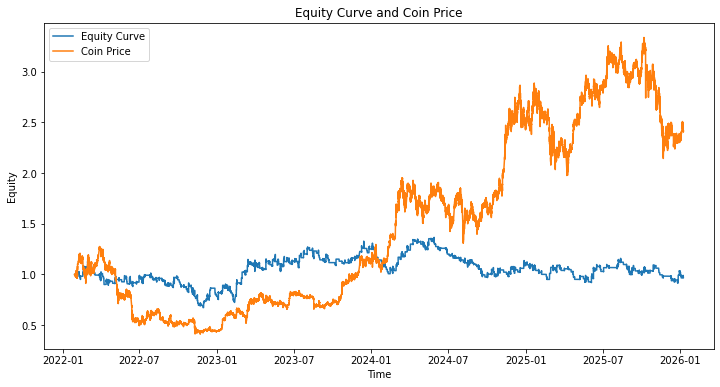

In [28]:
import matplotlib.pyplot as plt
coin_curve = df.groupby(df.index).last()['close']
equity_curve = result.equity_curve
plt.figure(figsize=(12, 6))
plt.plot(equity_curve.index, equity_curve.values/equity_curve.values[0], label='Equity Curve')
plt.plot(coin_curve.index, coin_curve.values/coin_curve.values[0], label='Coin Price')
plt.title('Equity Curve and Coin Price')
plt.xlabel('Time')
plt.ylabel('Equity')
plt.legend()
plt.show()

## 